# Lectura y Análisis

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from scipy.spatial.distance import euclidean
from scipy.stats import pearsonr, spearmanr, kendalltau
from sklearn.metrics import mean_squared_error

# Missing values
from scipy.interpolate import CubicSpline
from scipy.interpolate import PchipInterpolator

from sklearn.neighbors import NearestNeighbors

## Carga de datos

### Lectura de ficheros

Se leen los distintos fichero con la información meteorlógica.

Se establece una cota temporal a los datos de todos los ficheros.

In [24]:
dataframes = {}

def load(file, directory, start_date=None, end_date=None):
    file_path = directory + file + ".csv"
    print(f"Processing {file}...")
    
    try:
        df = pd.read_csv(file_path, parse_dates=['ts'], index_col='ts')
        df = df.sort_index()
        df_hourly = df.resample('h').mean()  # Resample by hour
        
        # Apply date filtering if start_date and end_date are provided
        if start_date and end_date:
            df_hourly = df_hourly.loc[start_date:end_date]
        print(df_hourly.iloc[0])
        print(df_hourly.iloc[-1])
        
        dataframes[file] = df_hourly
    except Exception as e:
        print(f"Error processing {file}: {e}")

In [25]:
# Read the CSV files
directory = "data/"

#########
# Dates #
#########
start_date = "2023-03-01"
end_date = "2025-02-28"

location = "la_laguna"

grafcan = "grafcan_la_laguna"
openmeteo_arpege = "openmeteo_la_laguna_arpege"
openmeteo_icon = "openmeteo_la_laguna_icon"

data_files = [grafcan,
              openmeteo_arpege,
              openmeteo_icon]
for file in data_files:
    load(file, directory, start_date, end_date)


Processing grafcan_la_laguna...


air_temperature          16.781813
atmospheric_pressure    981.684957
relative_humidity        79.808440
Name: 2023-03-01 00:00:00+00:00, dtype: float64
air_temperature          14.717612
atmospheric_pressure    977.198568
relative_humidity        82.326946
Name: 2025-02-28 23:00:00+00:00, dtype: float64
Processing openmeteo_la_laguna_arpege...
air_temperature          15.4
atmospheric_pressure    982.1
relative_humidity        88.0
Name: 2023-03-01 00:00:00+00:00, dtype: float64
air_temperature          15.3
atmospheric_pressure    977.4
relative_humidity        71.0
Name: 2025-02-28 23:00:00+00:00, dtype: float64
Processing openmeteo_la_laguna_icon...
air_temperature          17.1
atmospheric_pressure    982.3
relative_humidity        83.0
Name: 2023-03-01 00:00:00+00:00, dtype: float64
air_temperature          16.2
atmospheric_pressure    977.6
relative_humidity        69.0
Name: 2025-02-28 23:00:00+00:00, dtype: float64


## Visualización

In [26]:
def plot_datasets_comparison(dataframes, column):
    """
    Plot a specific column from each dataset (given as a list of filenames)
    for all common years.
    
    Parameters:
        datasets (list): List of dataset filenames (e.g., ['file1.csv', 'file2.csv', ...]).
        column (str): The column name to plot from each dataset.
    """
    print ("Plotting " + column)
    
    df_names = dataframes.keys()
    dfs = dataframes.values()
    # Align all dataframes on their timestamps by concatenating on axis=1 (inner join ensures common timestamps)
    # Using keys creates a hierarchical column index: top level is dataset name, lower level is the original columns.
    combined = pd.concat(dfs, axis=1, join='inner', keys=df_names)
    
    # Ensure the indicated column exists in every dataset
    for name in df_names:
        if column not in combined[name].columns:
            print(f"Column '{column}' not found in dataset '{name}'.")
            return

    # Get all common years from the combined index
    common_years = combined.index.year.unique()
    
    # Plot the indicated column for each dataset by year
    for year in common_years:
        df_year = combined[combined.index.year == year]
        plt.figure(figsize=(10, 6))
        for name in df_names:
            plt.plot(df_year.index, df_year[name][column],
                     label=f"{name}", linestyle='-', alpha=0.7)
        plt.title(f'Comparison Plot - Column "{column}" - Year {year}')
        plt.xlabel('Date')
        plt.ylabel('Value')
        plt.legend()
        plt.grid(True)
        plt.show()

### OpenMeteo

Plotting air_temperature


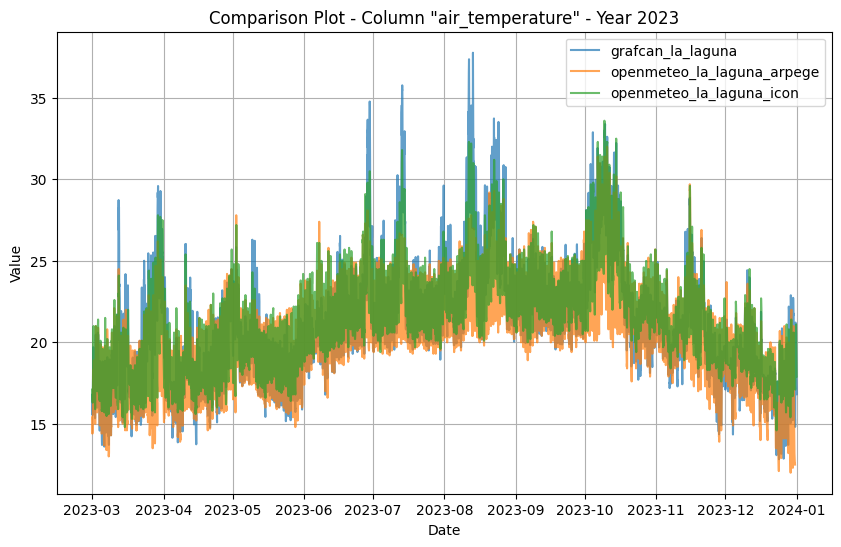

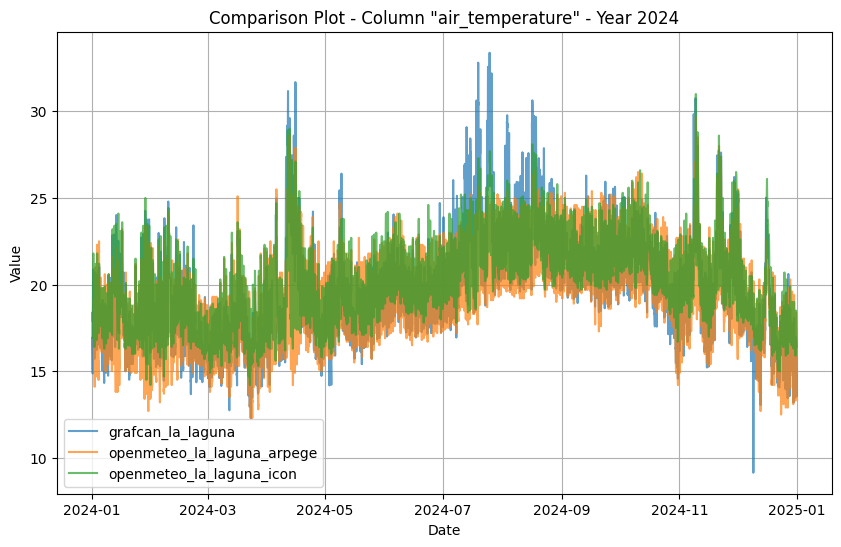

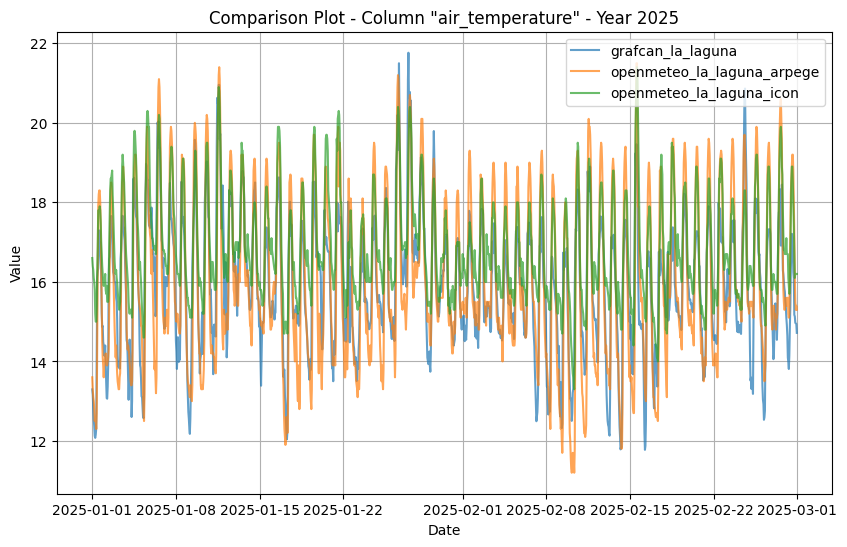

Plotting relative_humidity


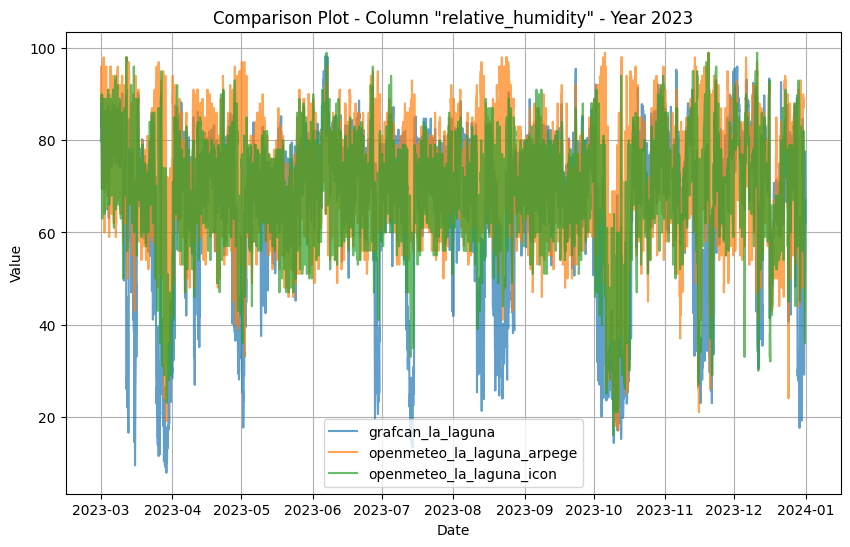

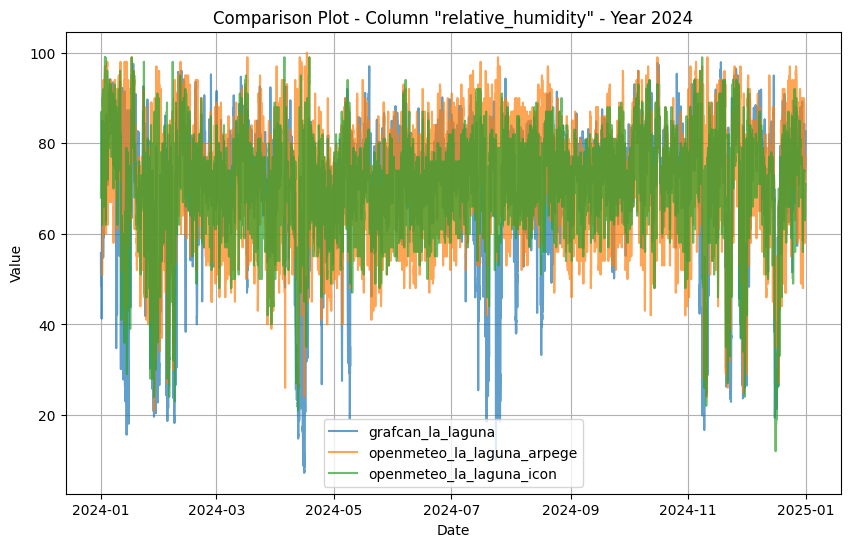

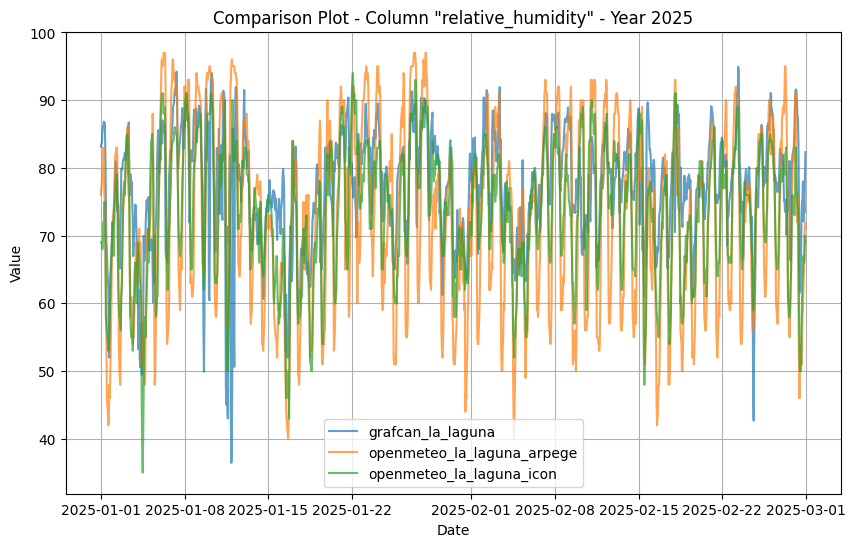

Plotting atmospheric_pressure


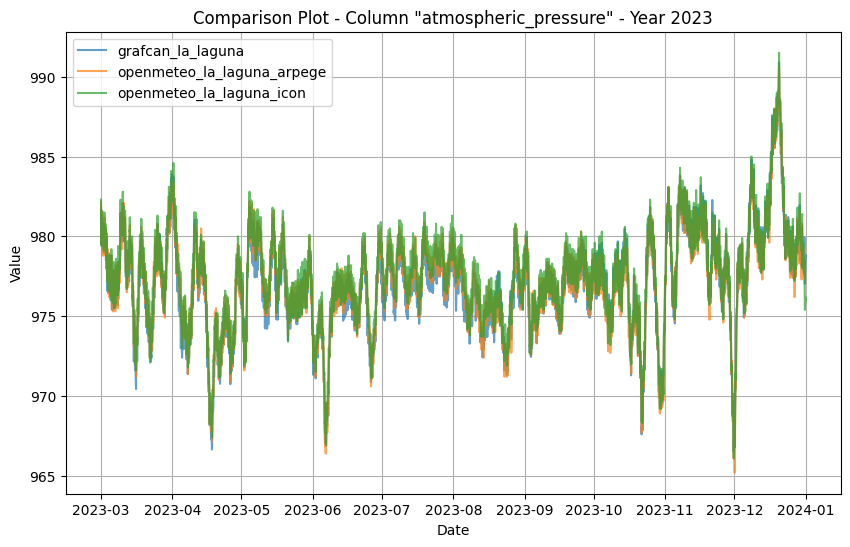

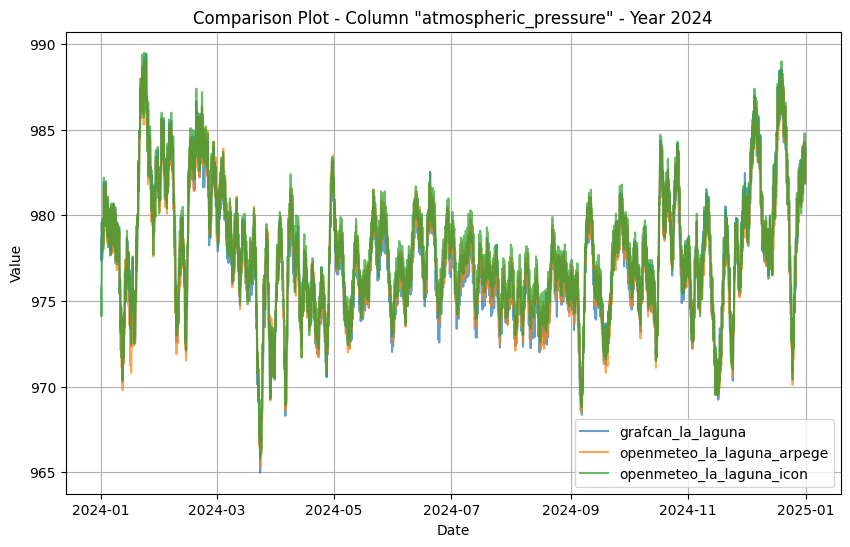

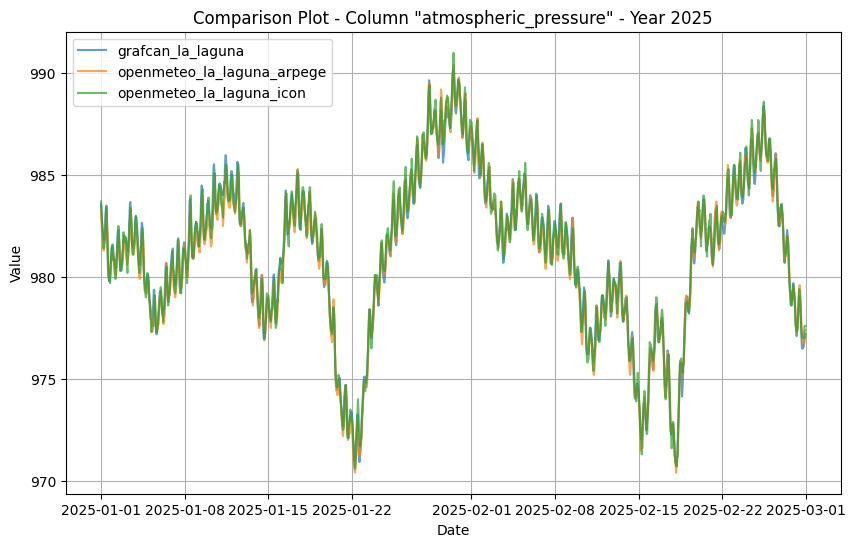

In [27]:
plot_datasets_comparison(dataframes, "air_temperature")
plot_datasets_comparison(dataframes, "relative_humidity")
plot_datasets_comparison(dataframes, "atmospheric_pressure")

## Horas faltantes

In [28]:
for file_key, df_hourly in dataframes.items():
    # Check for missing hours in the time series
    # Detect missing hours after resampling
    missing_hours = df_hourly[df_hourly.isna().any(axis=1)].index

    # Print missing hours if any
    if len(missing_hours) > 0:
        print(f"Missing hours in {file_key} after resampling:")
        print(missing_hours.tolist())
        print(len(missing_hours))
    else:
        print(f"No missing hours in {file_key} after resampling.")

Missing hours in grafcan_la_laguna after resampling:
[Timestamp('2024-04-03 11:00:00+0000', tz='UTC'), Timestamp('2024-04-03 12:00:00+0000', tz='UTC'), Timestamp('2024-04-03 13:00:00+0000', tz='UTC'), Timestamp('2024-04-03 14:00:00+0000', tz='UTC'), Timestamp('2024-04-03 15:00:00+0000', tz='UTC'), Timestamp('2024-04-03 16:00:00+0000', tz='UTC'), Timestamp('2024-04-03 17:00:00+0000', tz='UTC'), Timestamp('2024-04-03 18:00:00+0000', tz='UTC'), Timestamp('2024-04-03 19:00:00+0000', tz='UTC'), Timestamp('2024-04-03 20:00:00+0000', tz='UTC'), Timestamp('2024-04-03 21:00:00+0000', tz='UTC'), Timestamp('2024-04-03 22:00:00+0000', tz='UTC'), Timestamp('2024-04-03 23:00:00+0000', tz='UTC'), Timestamp('2024-04-04 00:00:00+0000', tz='UTC'), Timestamp('2024-04-04 01:00:00+0000', tz='UTC'), Timestamp('2024-04-04 02:00:00+0000', tz='UTC'), Timestamp('2024-04-04 03:00:00+0000', tz='UTC'), Timestamp('2024-04-04 04:00:00+0000', tz='UTC'), Timestamp('2024-04-04 05:00:00+0000', tz='UTC'), Timestamp('2024

### Manejo Horas faltantes

In [29]:
# Pchip Interpolation Algorithm
def pchip_interpolation(df):
    # Ensure index is datetime and convert to numeric (Unix timestamp in seconds)
    if not isinstance(df.index, pd.DatetimeIndex):
        raise ValueError("Index must be a DatetimeIndex.")

    numeric_index = df.index.astype('int64') // 10**9

    # Initialize artificial_value column with zeros if not present
    if "artificial_value" not in df.columns:
        df["artificial_value_flag"] = 0

    for col in df.columns:
        if col == "artificial_value":
            continue  # Skip flag column

        valid_mask = ~df[col].isna()

        if valid_mask.sum() >= 2:
            pchip = PchipInterpolator(numeric_index[valid_mask], df.loc[valid_mask, col])
            interpolated_values = pchip(numeric_index)

            # Mark artificially generated values before filling
            nan_mask = df[col].isna()
            df.loc[nan_mask, col] = interpolated_values[nan_mask]
            df.loc[nan_mask, "artificial_value_flag"] = 1
        else:
            print(f"Not enough data points to interpolate column '{col}'.")

    return df

#cs = CubicSpline(numeric_index[valid_mask], df.loc[valid_mask, col], bc_type='natural')

In [30]:
for file_key, df_hourly in dataframes.items():
    # Perform cubic spline interpolation on the dataframe
    pchip_interpolation(df_hourly)

## Comparativa datasets openmeteo

In [31]:
def datasets_similarity(file1, file2):
    # Remove .csv extension if present
    file1 = file1.replace(".csv", "")
    file2 = file2.replace(".csv", "")
    
    # Ensure datasets are loaded
    if file1 not in dataframes or file2 not in dataframes:
        print("One or both datasets are not loaded.")
        return
    
    # Retrieve dataframes and align by timestamp
    df1 = dataframes[file1].drop(columns=["artificial_value_flag"])
    df2 = dataframes[file2].drop(columns=["artificial_value_flag"])
    df1, df2 = df1.align(df2, join='inner')
    
    similarity_results = {}
    for column in df1.columns:
        if column in df2.columns:
            try:
                pearson_corr, _ = pearsonr(df1[column], df2[column])
                spearman_corr, _ = spearmanr(df1[column], df2[column])
                kendall_corr, _ = kendalltau(df1[column], df2[column])
                mse = mean_squared_error(df1[column], df2[column])
                euclid_dist = euclidean(df1[column], df2[column])
                
                similarity_results[column] = {
                    "Pearson": pearson_corr,
                    "Spearman": spearman_corr,
                    "Kendall": kendall_corr,
                    "MSE": mse,
                    "Euclidean Distance": euclid_dist
                }
            except Exception as e:
                print(f"Error calculating similarity for {column}: {e}")
    
    print(f"Similarity Metrics for {file1} vs {file2}")
    for col, metrics in similarity_results.items():
        print(f"  {col}:")
        for metric, value in metrics.items():
            print(f"    {metric}: {value:.4f}")


In [32]:
datasets_similarity(openmeteo_icon, grafcan)

Similarity Metrics for openmeteo_la_laguna_icon vs grafcan_la_laguna
  air_temperature:
    Pearson: 0.9010
    Spearman: 0.9113
    Kendall: 0.7608
    MSE: 2.6367
    Euclidean Distance: 215.0776
  atmospheric_pressure:
    Pearson: 0.9880
    Spearman: 0.9828
    Kendall: 0.8969
    MSE: 0.4902
    Euclidean Distance: 92.7397
  relative_humidity:
    Pearson: 0.5327
    Spearman: 0.5751
    Kendall: 0.4349
    MSE: 205.6620
    Euclidean Distance: 1899.5088


In [33]:
datasets_similarity(openmeteo_arpege, grafcan)

Similarity Metrics for openmeteo_la_laguna_arpege vs grafcan_la_laguna
  air_temperature:
    Pearson: 0.8372
    Spearman: 0.8697
    Kendall: 0.7077
    MSE: 4.3515
    Euclidean Distance: 276.3019
  atmospheric_pressure:
    Pearson: 0.9887
    Spearman: 0.9845
    Kendall: 0.9019
    MSE: 0.2917
    Euclidean Distance: 71.5328
  relative_humidity:
    Pearson: 0.3249
    Spearman: 0.4390
    Kendall: 0.3381
    MSE: 317.8278
    Euclidean Distance: 2361.3494


### Selección de datasets

In [34]:
ned_df_openmeteo = "openmeteo_" + location
dataframes[ned_df_openmeteo] = dataframes[openmeteo_icon].copy()
dataframes[ned_df_openmeteo]["atmospheric_pressure"] = dataframes[openmeteo_arpege]["atmospheric_pressure"].copy()
dataframes[ned_df_openmeteo]["artificial_value_flag"] += dataframes[openmeteo_arpege]["artificial_value_flag"]

# Erase individual dataframes
del dataframes[openmeteo_icon]
del dataframes[openmeteo_arpege]

## Detección de outliers



### Análisis IQR

In [35]:
def detect_outliers_iqr(df, columns, threshold=1.5, return_indices=False):
    """
    Detects and plots outliers in each numerical column of a Pandas DataFrame using the Interquartile Range (IQR) method.
    Optionally returns indices of the detected outliers.
    
    Parameters:
        df (pd.DataFrame): The input DataFrame.
        threshold (float): The multiplier for the IQR to determine outlier boundaries.
        return_indices (bool): If True, also return a dictionary of outlier indices for each column.
        
    Returns:
        outliers_dict (dict): A dictionary containing outlier values for each numerical column.
        outlier_indices_dict (dict, optional): A dictionary containing outlier row indices for each numerical column.
    """
    outliers_dict = {}
    outlier_indices_dict = {}
    
    for column in df[columns].columns:
        # Calculate IQR-based bounds
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        
        lower_bound = Q1 - threshold * IQR
        upper_bound = Q3 + threshold * IQR
        
        # Identify outliers
        outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)][column]
        outliers_dict[column] = outliers.tolist()
        outlier_indices_dict[column] = outliers.index.tolist()
        
        # Create subplots for boxplot and histogram
        fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
        
        # Boxplot on the left with outliers highlighted
        ax1.boxplot(df[column], vert=False)
        ax1.scatter(outliers, [1] * len(outliers), color='red', label='Outliers')
        ax1.set_title(f'Boxplot of {column}')  # Fixed typo here
        ax1.set_xlabel(column)
        ax1.legend()
        
        # Histogram on the right with bounds indicated
        ax2.hist(df[column], bins=30, color='skyblue', edgecolor='black', alpha=0.7)
        ax2.axvline(lower_bound, color='red', linestyle='dashed', linewidth=1, label='Lower bound')
        ax2.axvline(upper_bound, color='red', linestyle='dashed', linewidth=1, label='Upper bound')
        ax2.set_title(f'Histogram of {column}')
        ax2.set_xlabel(column)
        ax2.set_ylabel('Frequency')
        ax2.legend()
        
        plt.tight_layout()
        plt.show()
    
    if return_indices:
        return outliers_dict, outlier_indices_dict
    return outliers_dict


Processing grafcan_la_laguna:


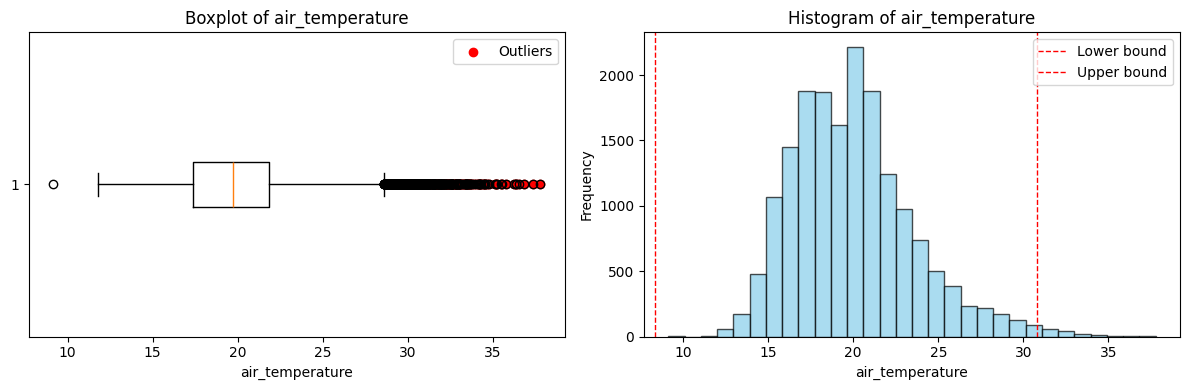

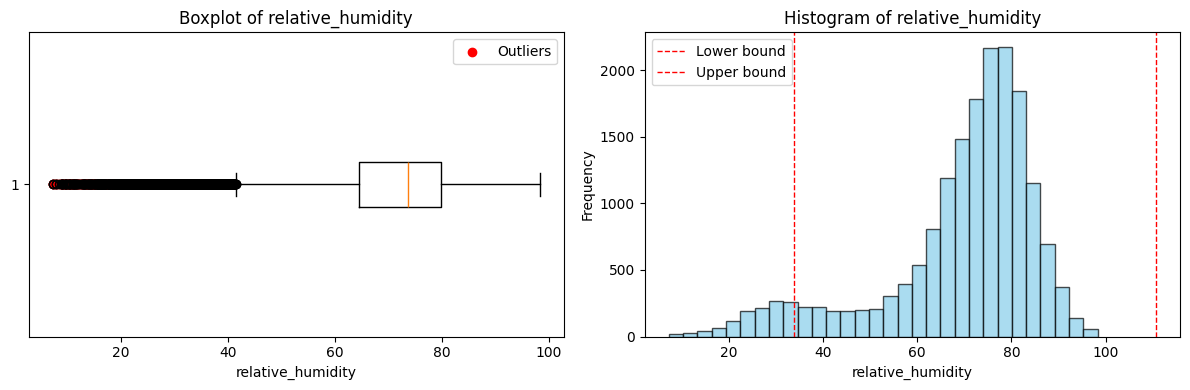

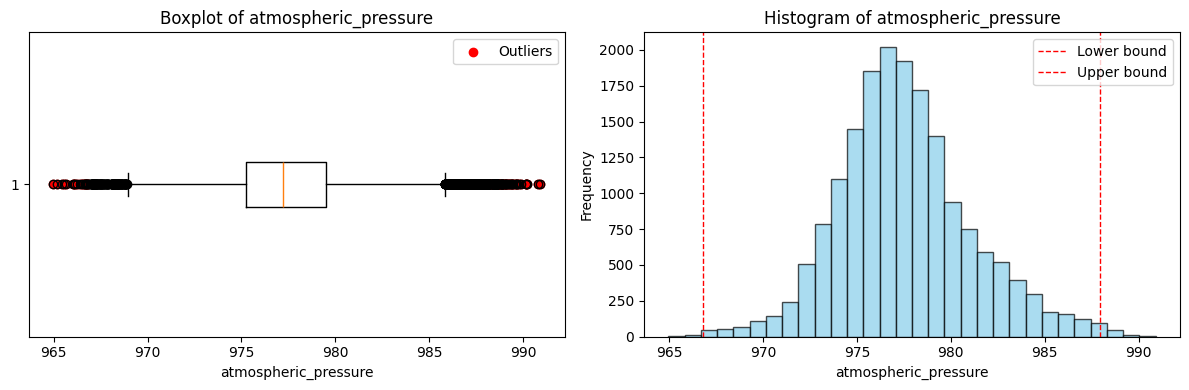

  air_temperature outlier row indices: [Timestamp('2023-06-28 10:00:00+0000', tz='UTC'), Timestamp('2023-06-28 12:00:00+0000', tz='UTC'), Timestamp('2023-06-28 13:00:00+0000', tz='UTC'), Timestamp('2023-06-28 14:00:00+0000', tz='UTC'), Timestamp('2023-06-28 15:00:00+0000', tz='UTC'), Timestamp('2023-06-28 16:00:00+0000', tz='UTC'), Timestamp('2023-06-28 17:00:00+0000', tz='UTC'), Timestamp('2023-06-28 18:00:00+0000', tz='UTC'), Timestamp('2023-06-28 19:00:00+0000', tz='UTC'), Timestamp('2023-06-28 20:00:00+0000', tz='UTC'), Timestamp('2023-06-29 08:00:00+0000', tz='UTC'), Timestamp('2023-06-29 09:00:00+0000', tz='UTC'), Timestamp('2023-06-29 10:00:00+0000', tz='UTC'), Timestamp('2023-06-29 11:00:00+0000', tz='UTC'), Timestamp('2023-06-29 12:00:00+0000', tz='UTC'), Timestamp('2023-06-29 13:00:00+0000', tz='UTC'), Timestamp('2023-06-29 14:00:00+0000', tz='UTC'), Timestamp('2023-06-29 15:00:00+0000', tz='UTC'), Timestamp('2023-06-29 16:00:00+0000', tz='UTC'), Timestamp('2023-06-29 17:00:0

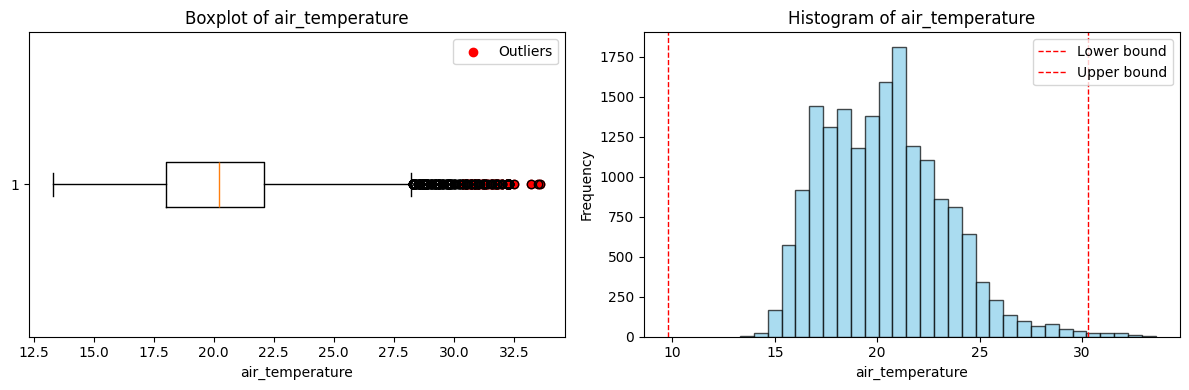

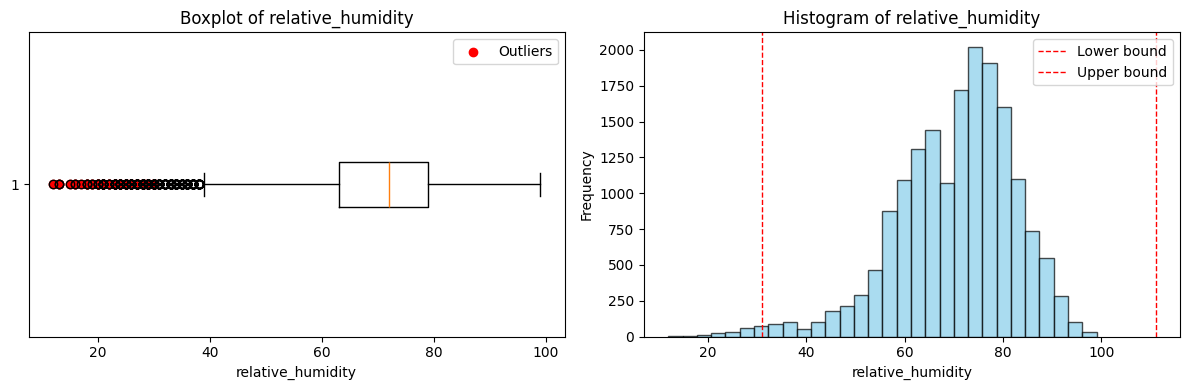

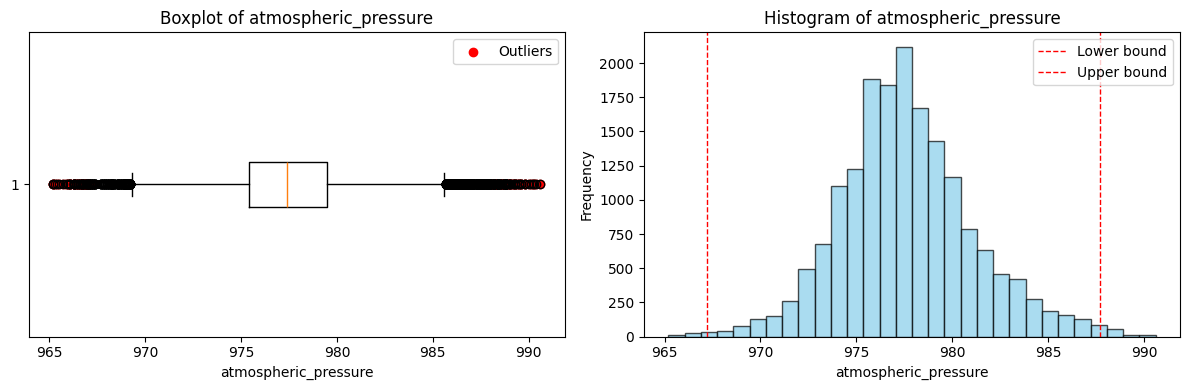

  air_temperature outlier row indices: [Timestamp('2023-06-29 14:00:00+0000', tz='UTC'), Timestamp('2023-07-13 12:00:00+0000', tz='UTC'), Timestamp('2023-07-13 13:00:00+0000', tz='UTC'), Timestamp('2023-07-13 14:00:00+0000', tz='UTC'), Timestamp('2023-07-13 15:00:00+0000', tz='UTC'), Timestamp('2023-07-13 16:00:00+0000', tz='UTC'), Timestamp('2023-07-13 17:00:00+0000', tz='UTC'), Timestamp('2023-08-11 12:00:00+0000', tz='UTC'), Timestamp('2023-08-11 13:00:00+0000', tz='UTC'), Timestamp('2023-08-11 14:00:00+0000', tz='UTC'), Timestamp('2023-08-11 15:00:00+0000', tz='UTC'), Timestamp('2023-08-11 16:00:00+0000', tz='UTC'), Timestamp('2023-08-11 17:00:00+0000', tz='UTC'), Timestamp('2023-08-12 11:00:00+0000', tz='UTC'), Timestamp('2023-08-12 12:00:00+0000', tz='UTC'), Timestamp('2023-08-12 13:00:00+0000', tz='UTC'), Timestamp('2023-08-12 14:00:00+0000', tz='UTC'), Timestamp('2023-08-12 15:00:00+0000', tz='UTC'), Timestamp('2023-08-12 16:00:00+0000', tz='UTC'), Timestamp('2023-08-12 17:00:0

In [36]:
threshold = 2
columns = ["air_temperature", "relative_humidity", "atmospheric_pressure"]

for file_key, df_hourly in dataframes.items():
    print(f"Processing {file_key}:")
    
    # Use the modified function to get both outlier values and their indices
    outliers, outlier_indices = detect_outliers_iqr(df_hourly, columns, threshold, return_indices=True)
    
    # Print outliers for each column
    for column, indices in outlier_indices.items():
        print(f"  {column} outlier row indices: {indices}")
    
    # Combine all outlier indices from every column
    all_outlier_indices = set()
    for indices in outlier_indices.values():
        all_outlier_indices.update(indices)
    
    # Remove rows with any detected outlier
    # df_clean = df_hourly.drop(list(all_outlier_indices))
    # dataframes[file_key] = df_clean
    
    print(f"Detected {len(all_outlier_indices)} rows with outliers from {file_key}.\n")

### KNN

Processing grafcan_la_laguna for KNN outlier detection...
air_temperature


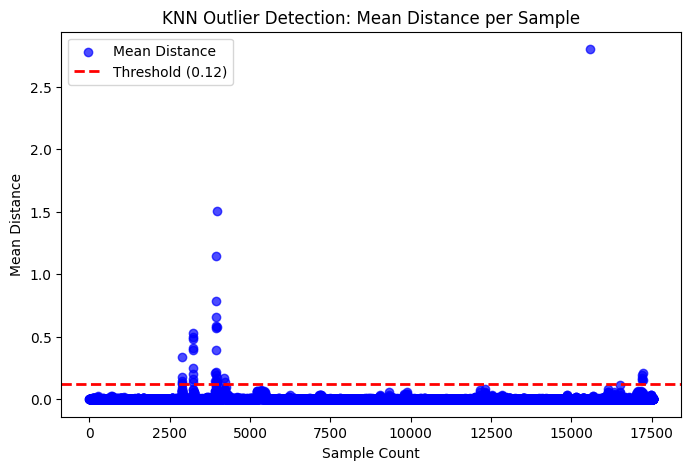

Detected 37 outliers at indices: [ 2871  2892  2893  2894  3225  3226  3227  3229  3230  3231  3232  3233
  3234  3920  3922  3924  3925  3926  3927  3928  3929  3930  3950  3951
  3952  3968  3969  3970  3971  4188  4234 15587 17189 17190 17191 17238
 17239]
atmospheric_pressure


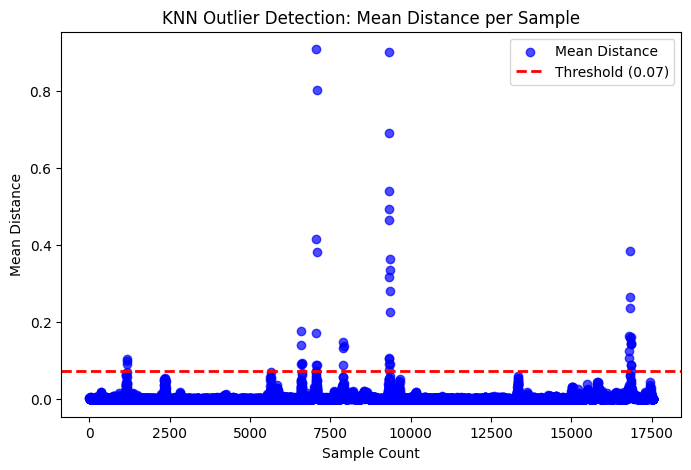

Detected 47 outliers at indices: [ 1155  1156  1157  6593  6594  6596  6603  6604  7063  7064  7065  7066
  7067  7068  7069  7883  7905  7906  7907  9317  9319  9326  9327  9328
  9329  9330  9331  9332  9334  9339  9340  9341  9342  9343 16786 16787
 16788 16834 16835 16836 16837 16844 16845 16846 16847 16848 16849]
relative_humidity


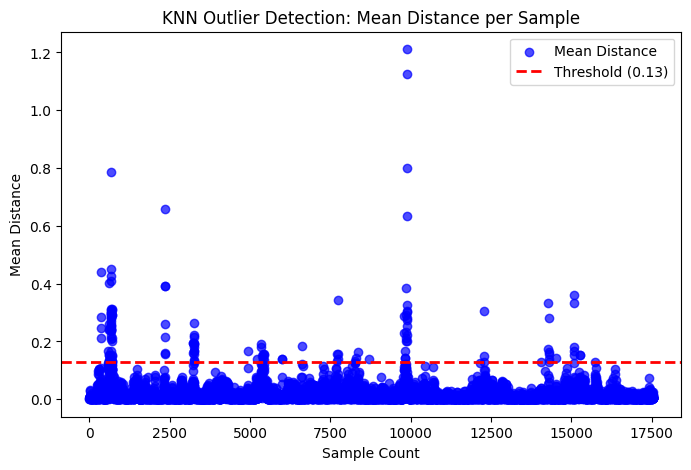

Detected 137 outliers at indices: [  348   355   356   357   591   593   601   602   604   607   611   613
   614   653   654   657   658   659   660   663   666   667   668   669
   670   671   672   673   674   675   676   677   678   679   680   681
   682   683   684   685   686   687   688   689   690   693   694   695
   698   701   702   703  2339  2340  2341  2342  2343  2363  2364  3225
  3226  3229  3239  3240  3241  3242  3243  3244  3245  3246  3247  3248
  3249  3250  4949  5218  5345  5346  5380  5388  5389  5422  5424  5443
  5997  6003  6606  7690  7691  7745  7747  7748  8261  8307  8348  8716
  9803  9804  9806  9807  9816  9863  9864  9865  9866  9867  9868  9869
  9870  9878  9879  9880  9881  9882  9883  9884  9885  9886 12269 12270
 14040 14282 14285 14289 14291 14292 14296 14299 14523 15068 15072 15073
 15074 15077 15261 15262 15745]
Processing openmeteo_la_laguna for KNN outlier detection...
air_temperature


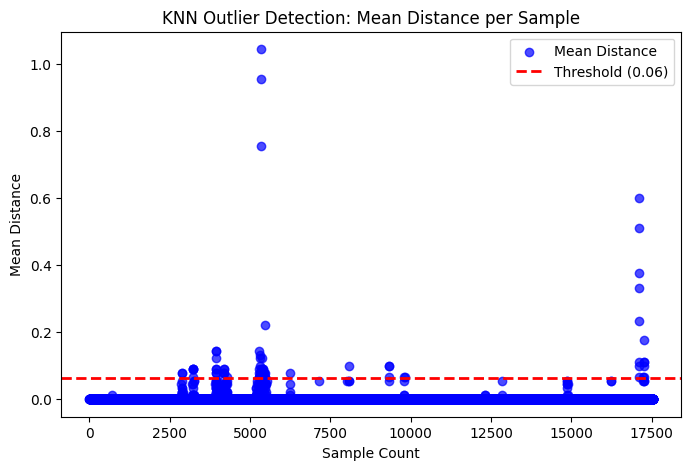

Detected 78 outliers at indices: [ 2869  2893  3227  3229  3230  3231  3232  3923  3924  3925  3928  3948
  3952  3953  4168  4188  4189  4190  4192  4283  5268  5269  5271  5272
  5292  5293  5294  5295  5296  5315  5317  5318  5320  5321  5338  5339
  5340  5341  5343  5344  5346  5362  5363  5364  5369  5387  5389  5391
  5392  5415  5437  5438  5439  5459  5462  5463  5464  6231  8072  9309
  9310  9311  9805  9806 17090 17091 17092 17093 17094 17095 17096 17097
 17215 17260 17261 17262 17263 17264]
atmospheric_pressure


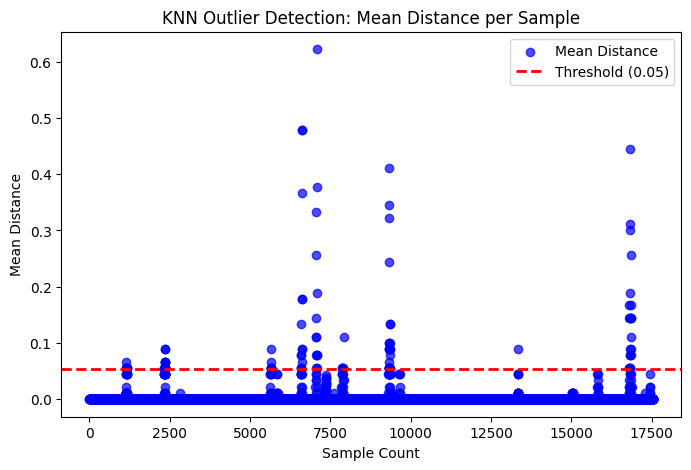

Detected 107 outliers at indices: [ 1133  1147  1148  1154  1155  1159  2332  2333  2336  2337  2341  2342
  2343  2344  2345  2346  2348  2355  2357  2358  5635  5636  5637  5640
  5641  5642  5643  6591  6592  6593  6594  6595  6596  6600  6601  6602
  6603  6604  6605  6606  6607  7043  7044  7055  7056  7064  7065  7066
  7067  7068  7069  7072  7077  7079  7857  7858  7894  7895  7907  9317
  9318  9319  9320  9321  9324  9325  9326  9327  9328  9329  9330  9331
  9332  9333  9335  9336  9338  9339  9340  9341  9342  9343  9344  9346
 13338 16786 16787 16788 16800 16811 16820 16821 16825 16833 16834 16835
 16836 16837 16838 16839 16841 16844 16845 16846 16847 16848 16860]
relative_humidity


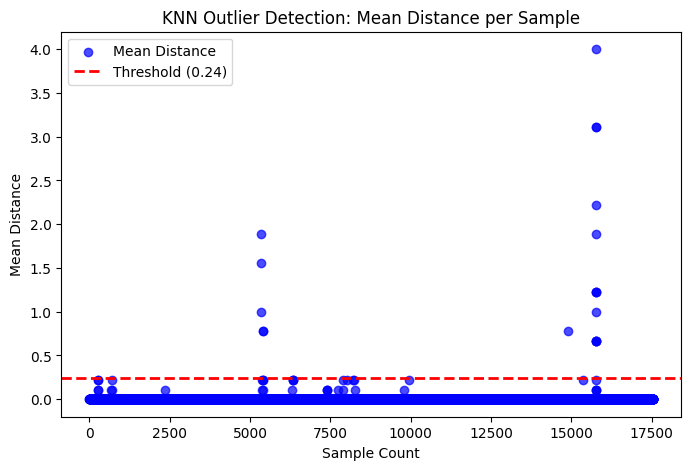

Detected 19 outliers at indices: [ 5338  5339  5340  5390  5391 14891 15751 15752 15753 15754 15755 15756
 15757 15758 15759 15761 15762 15766 15767]


In [37]:
def knn_outlier_detection(data, k=10, threshold=4):
    """
    Detect outliers using K-Nearest Neighbors.
    
    Parameters:
    - data: 1D numpy array of values.
    - k: Number of neighbors to consider.
    - threshold: Multiplier for the mean distance to determine outliers.
    
    Returns:
    - outliers: Indices of detected outliers.
    """
    data = data.reshape(-1, 1)  # Reshape for sklearn compatibility
    
    nbrs = NearestNeighbors(n_neighbors=k)
    nbrs.fit(data)
    distances, _ = nbrs.kneighbors(data)
    
    mean_distances = distances[:, 1:].mean(axis=1)  # Ignore self-distance (0)
    
    threshold_value = mean_distances.mean() + threshold * mean_distances.std()
    outliers = np.where(mean_distances > threshold_value)[0]
    
    # Plot distance distribution with better bin scaling
    plt.figure(figsize=(8, 5))
    plt.scatter(np.arange(len(mean_distances)), mean_distances, color='b', alpha=0.7, label='Mean Distance')
    plt.axhline(threshold_value, color='r', linestyle='dashed', linewidth=2,
                label=f'Threshold ({threshold_value:.2f})')
    #plt.yscale('log')  # Log scale for y-axis
    plt.xlabel('Sample Count')
    plt.ylabel('Mean Distance')
    plt.title('KNN Outlier Detection: Mean Distance per Sample')
    plt.legend()
    plt.show()
    
    print(f"Detected {len(outliers)} outliers at indices: {outliers}")
    
    return outliers

for name, df in dataframes.items(): 
    print(f"Processing {name} for KNN outlier detection...")
    
    # Flag outliers initialized at 0
    flag = np.zeros(len(df), dtype=int)

    print("air_temperature")
    data = df["air_temperature"].values
    outliers = knn_outlier_detection(data)
    flag[outliers] = 1

    print("atmospheric_pressure")
    data = df["atmospheric_pressure"].values
    outliers = knn_outlier_detection(data)
    flag[outliers] = 1
    
    print("relative_humidity")
    data = df["relative_humidity"].values
    outliers = knn_outlier_detection(data)
    flag[outliers] = 1

    # Assign this flag array as a new column
    df["outlier_flag"] = flag

Plotting histogram for grafcan_la_laguna...


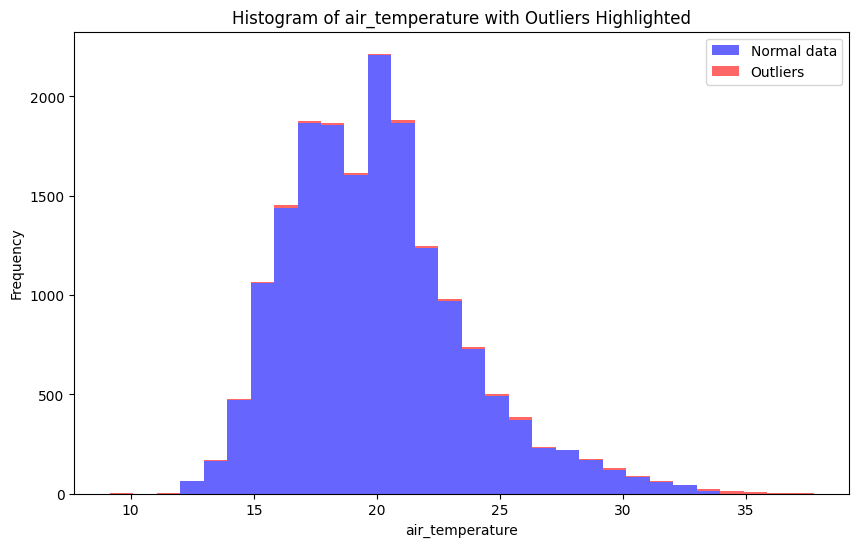

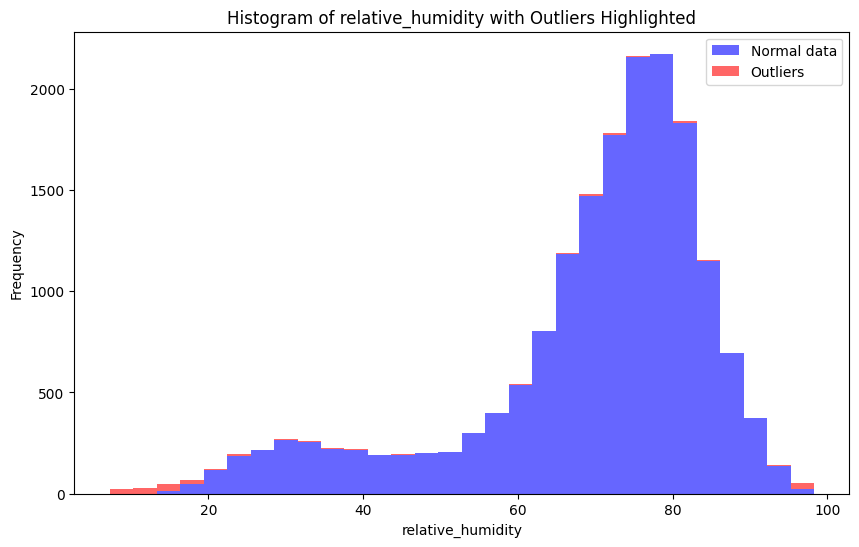

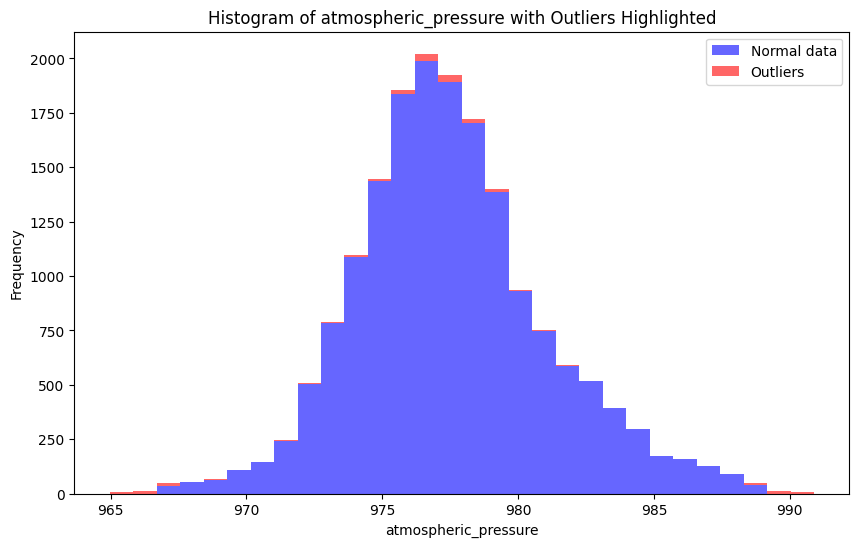

Plotting histogram for openmeteo_la_laguna...


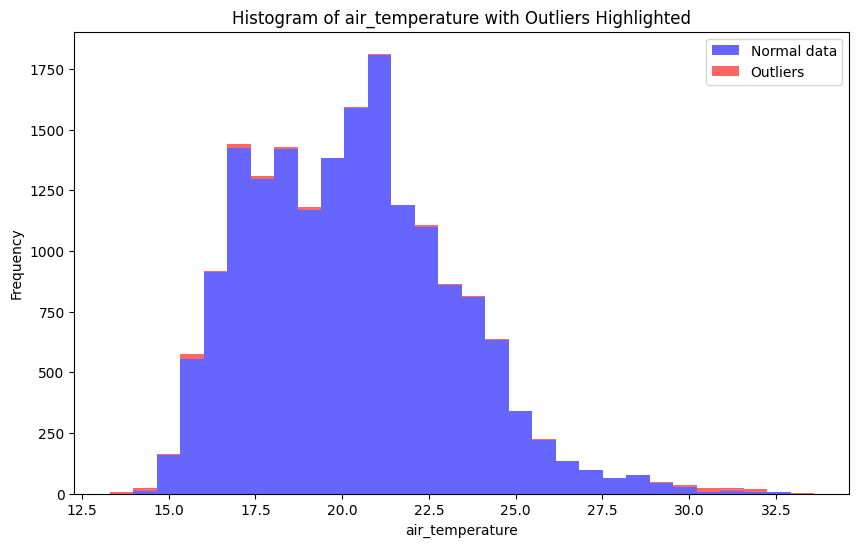

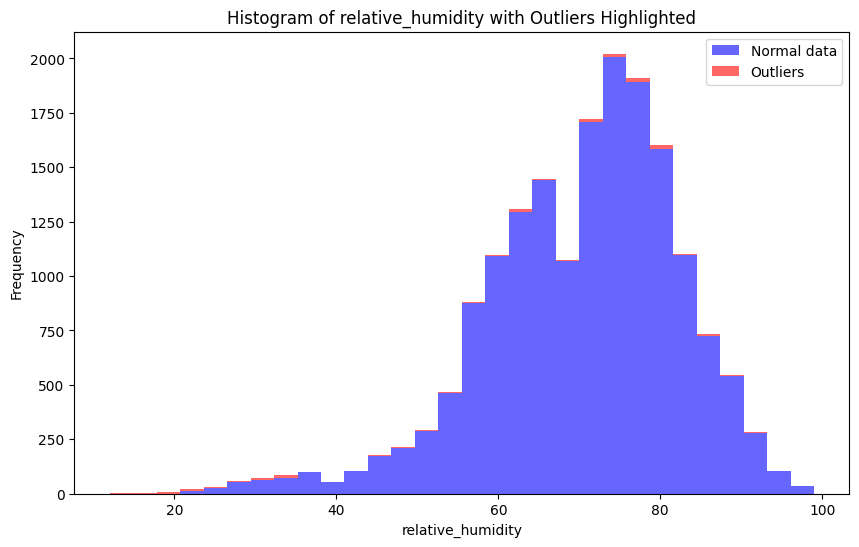

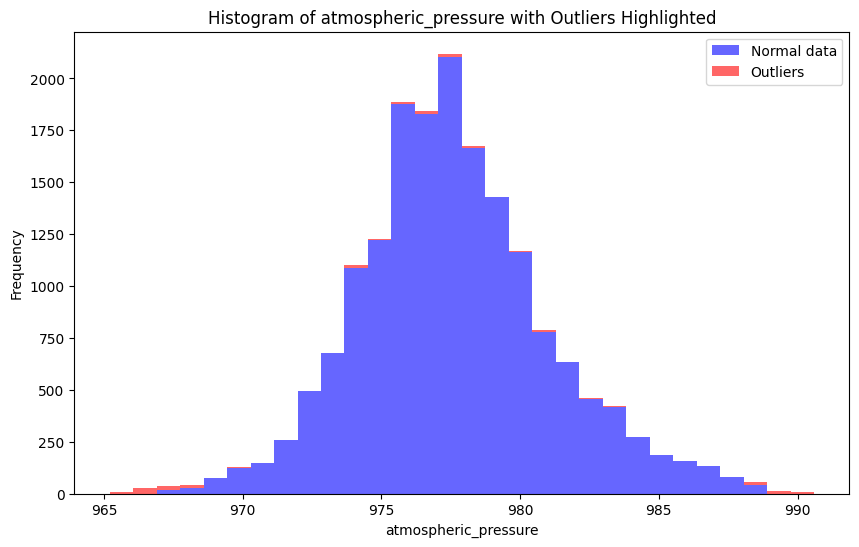

In [38]:
def plot_histogram_with_outliers(df, column, outlier_flag_column='outlier_flag', bins=30):
    """
    Plots a histogram for a specified column in the DataFrame, highlighting outliers.
    
    Parameters:
    - df: DataFrame containing the data.
    - column: Column name (string) for which to plot the histogram.
    - outlier_flag_column: Column name (string) containing the outlier flags (default 'outlier_flag').
    - bins: Number of bins for the histogram (default 30).
    """
    plt.figure(figsize=(10, 6))
    

    # Define bin edges based on the full dataset
    bin_edges = np.histogram_bin_edges(df[column], bins=bins)
    
    # Plot normal data histogram
    plt.hist([df.loc[df[outlier_flag_column] == 0, column], df.loc[df[outlier_flag_column] == 1, column]], stacked=True, bins=bin_edges, 
             color=['blue', 'red'], alpha=0.6, label=['Normal data', 'Outliers'])
    
    plt.xlabel(column)
    plt.ylabel("Frequency")
    #plt.yscale('log')  # Log scale for y-axis
    plt.title(f"Histogram of {column} with Outliers Highlighted")
    plt.legend()
    plt.show()

# Example usage:
for df_key in dataframes.keys():
    print(f"Plotting histogram for {df_key}...")
    plot_histogram_with_outliers(dataframes[df_key], "air_temperature")
    plot_histogram_with_outliers(dataframes[df_key], "relative_humidity")
    plot_histogram_with_outliers(dataframes[df_key], "atmospheric_pressure")

## Exploración frecuencias - Fourier

In [39]:
def plot_frequencies(df, column, freq_min, freq_max, top_n=3, sampling_interval=3600):
    values = df[column].values  # Extraer la columna de valores
    
    fft_result = np.fft.fft(values)  # Calcular la FFT
    frequencies = np.fft.fftfreq(len(values), d=sampling_interval)  # Calcular las frecuencias
    
    # Solo conservar las frecuencias positivas
    positive_frequencies = frequencies[:len(values) // 2]
    positive_fft_result = fft_result[:len(values) // 2]
    magnitude = np.abs(positive_fft_result)
    
    # Filtrar las frecuencias dentro del rango deseado
    mask = (positive_frequencies >= freq_min) & (positive_frequencies <= freq_max)
    filtered_frequencies = positive_frequencies[mask]
    filtered_magnitude = magnitude[mask]
    
    # Encontrar los índices de las N frecuencias con mayor magnitud
    top_indices = np.argsort(filtered_magnitude)[-top_n:]
    
    # Imprimir las N frecuencias principales
    print(f"Top {top_n} frequencies with highest magnitude:")
    for idx in top_indices:
        frequency_hz = filtered_frequencies[idx]
        period_hours = 1 / (frequency_hz * 3600)
        print(f"Frequency: {frequency_hz:.8f} Hz, Period: {period_hours:.2f} hours, Magnitude: {filtered_magnitude[idx]:.4f}")
    
    # Graficar el espectro de frecuencia con escala logarítmica en el eje X
    plt.figure(figsize=(10, 6))
    plt.plot(filtered_frequencies, filtered_magnitude, label='Frequency Spectrum')
    
    # Resaltar las N frecuencias principales
    top_frequencies = filtered_frequencies[top_indices]
    top_magnitudes = filtered_magnitude[top_indices]
    plt.scatter(top_frequencies, top_magnitudes, color='red', zorder=5, label=f'Top {top_n} Frequencies')
    
    # Configurar escala logarítmica para el eje X
    plt.xscale('log')
    plt.xlabel('Frequency (Hz, log scale)')
    plt.ylabel('Magnitude')
    plt.title(f'{column}: Frequency Spectrum between {freq_min} Hz and {freq_max} Hz')
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.legend()
    
    plt.tight_layout()
    plt.show()

Plotting frequencies for grafcan_la_laguna...
Top 5 frequencies with highest magnitude:
Frequency: 0.00000024 Hz, Period: 1169.60 hours, Magnitude: 6114.8545
Frequency: 0.00000011 Hz, Period: 2506.29 hours, Magnitude: 6306.0925
Frequency: 0.00000002 Hz, Period: 17544.00 hours, Magnitude: 7857.5862
Frequency: 0.00001157 Hz, Period: 24.00 hours, Magnitude: 16591.9227
Frequency: 0.00000003 Hz, Period: 8772.00 hours, Magnitude: 27621.5186


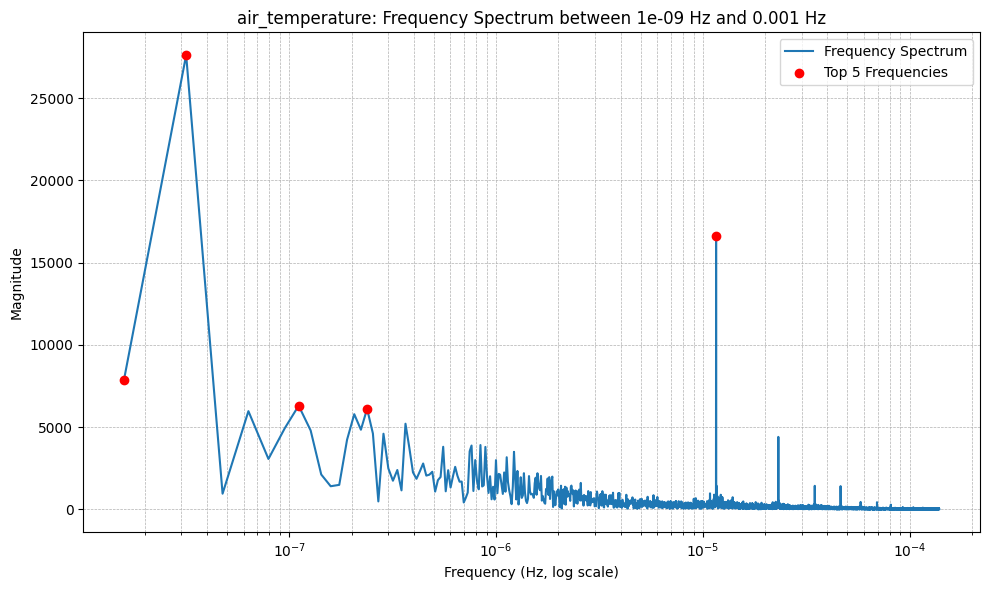

Top 5 frequencies with highest magnitude:
Frequency: 0.00000030 Hz, Period: 923.37 hours, Magnitude: 31050.4880
Frequency: 0.00000011 Hz, Period: 2506.29 hours, Magnitude: 31767.6582
Frequency: 0.00000002 Hz, Period: 17544.00 hours, Magnitude: 31958.7750
Frequency: 0.00000024 Hz, Period: 1169.60 hours, Magnitude: 39646.5803
Frequency: 0.00001157 Hz, Period: 24.00 hours, Magnitude: 40474.5705


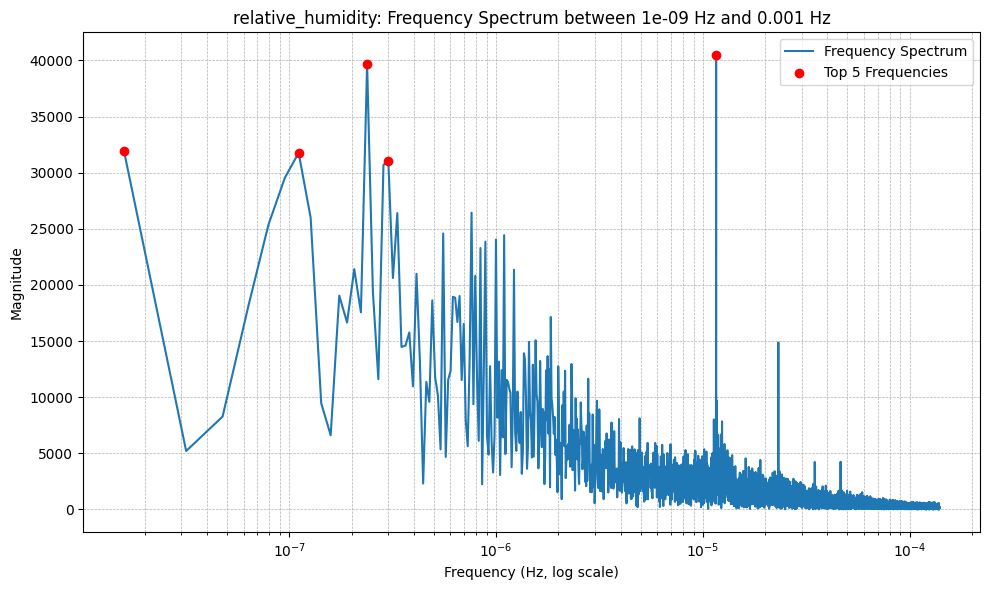

Top 5 frequencies with highest magnitude:
Frequency: 0.00000016 Hz, Period: 1754.40 hours, Magnitude: 6717.8432
Frequency: 0.00002315 Hz, Period: 12.00 hours, Magnitude: 7537.5908
Frequency: 0.00000032 Hz, Period: 877.20 hours, Magnitude: 7985.1119
Frequency: 0.00000006 Hz, Period: 4386.00 hours, Magnitude: 11432.8576
Frequency: 0.00000003 Hz, Period: 8772.00 hours, Magnitude: 20171.5875


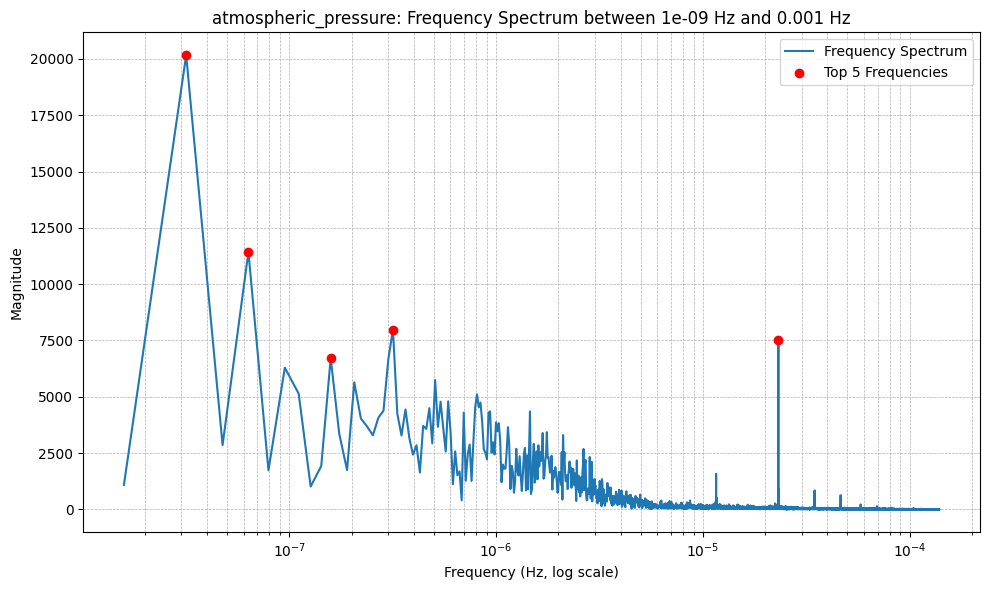

Plotting frequencies for openmeteo_la_laguna...
Top 5 frequencies with highest magnitude:
Frequency: 0.00000011 Hz, Period: 2506.29 hours, Magnitude: 4222.2050
Frequency: 0.00002315 Hz, Period: 12.00 hours, Magnitude: 6090.0557
Frequency: 0.00000002 Hz, Period: 17544.00 hours, Magnitude: 6465.4876
Frequency: 0.00001157 Hz, Period: 24.00 hours, Magnitude: 17126.9960
Frequency: 0.00000003 Hz, Period: 8772.00 hours, Magnitude: 24538.4319


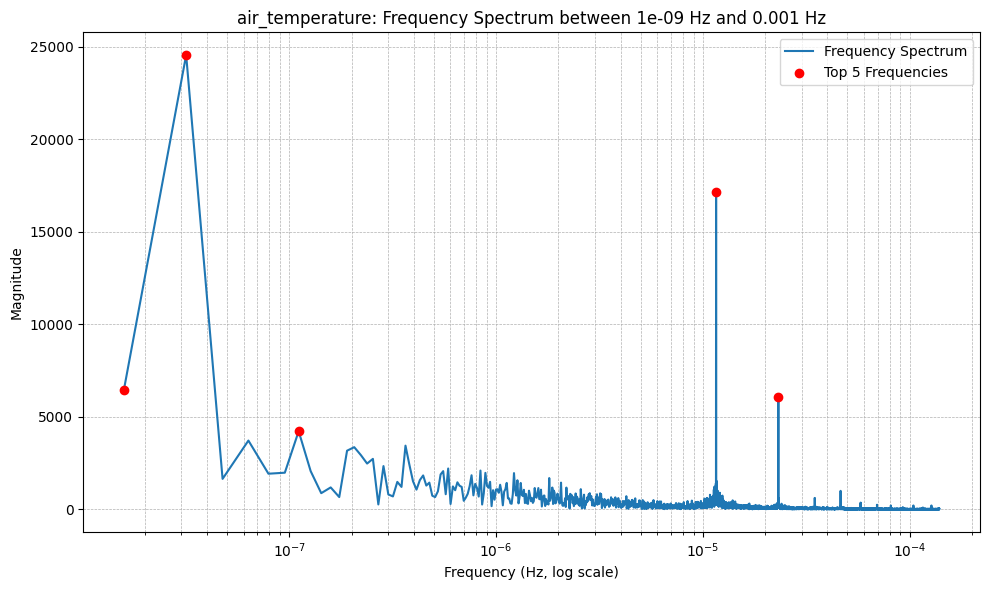

Top 5 frequencies with highest magnitude:
Frequency: 0.00000011 Hz, Period: 2506.29 hours, Magnitude: 16338.1063
Frequency: 0.00000024 Hz, Period: 1169.60 hours, Magnitude: 17074.8192
Frequency: 0.00000002 Hz, Period: 17544.00 hours, Magnitude: 17411.9118
Frequency: 0.00002315 Hz, Period: 12.00 hours, Magnitude: 27106.2827
Frequency: 0.00001157 Hz, Period: 24.00 hours, Magnitude: 89211.1156


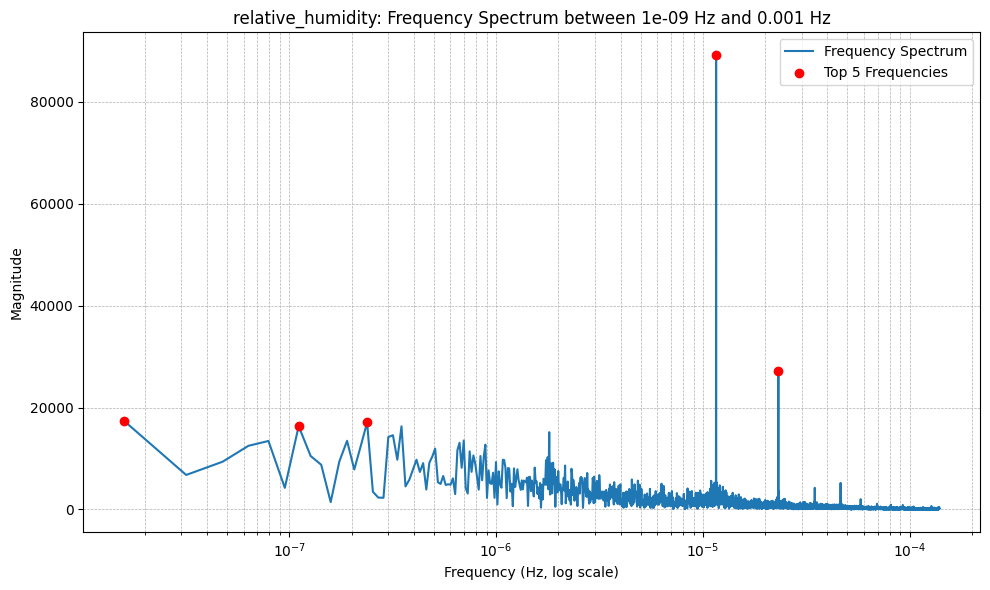

Top 5 frequencies with highest magnitude:
Frequency: 0.00000016 Hz, Period: 1754.40 hours, Magnitude: 7060.5965
Frequency: 0.00002315 Hz, Period: 12.00 hours, Magnitude: 7273.3078
Frequency: 0.00000032 Hz, Period: 877.20 hours, Magnitude: 7880.3911
Frequency: 0.00000006 Hz, Period: 4386.00 hours, Magnitude: 11378.0836
Frequency: 0.00000003 Hz, Period: 8772.00 hours, Magnitude: 17539.3395


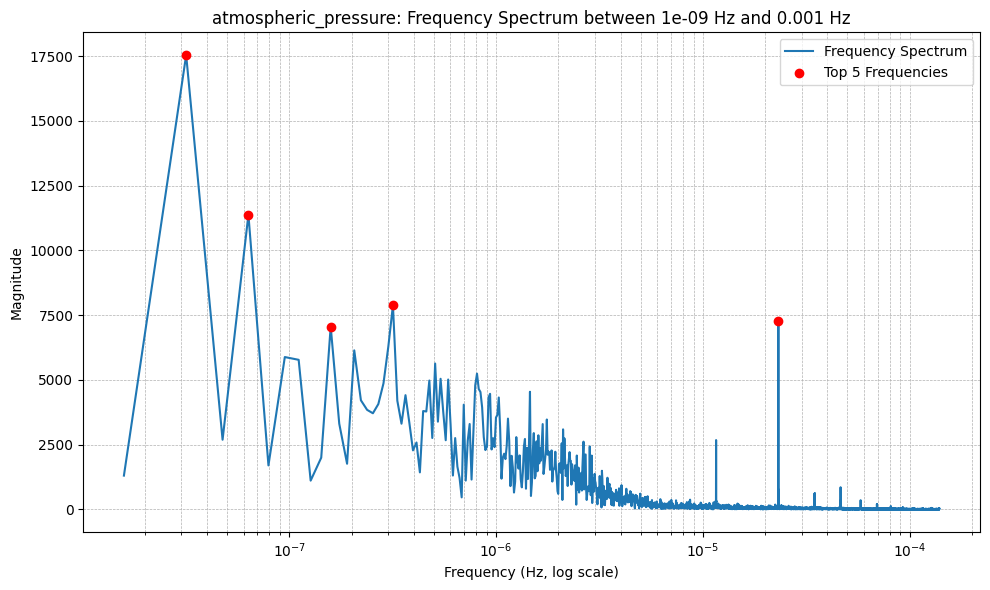

In [40]:
min_frequency = 10**-9
max_frequency = 10**-3
top_n = 5

for name, df in dataframes.items():
  print(f"Plotting frequencies for {name}...")
  plot_frequencies(df, "air_temperature", min_frequency, max_frequency, top_n)
  plot_frequencies(df, "relative_humidity", min_frequency, max_frequency, top_n)
  plot_frequencies(df, "atmospheric_pressure", min_frequency, max_frequency, top_n)

## Adición datos temporales

In [41]:
def add_time_features(df): 
    # Extract hour and minute to get a more continuous representation of time within a day
    df.index.name = "time"
    df.reset_index(inplace=True)

    df['time'] = pd.to_datetime(df['time'])
    hours = df['time'].dt.hour
    minutes  = df['time'].dt.minute
    hour_fraction = hours + minutes / 60.0

    # Convert the hour fraction into sine and cosine features to capture cyclical patterns (period = 24 hours)
    df['sin_day'] = np.sin(2 * np.pi * hour_fraction / 24)
    df['cos_day'] = np.cos(2 * np.pi * hour_fraction / 24)

    # Extract day of the week (0 = Monday, 6 = Sunday)
    day_of_week = df['time'].dt.weekday
    week_fraction = day_of_week + hour_fraction / 24.0  

    df['sin_week'] = np.sin(2 * np.pi * week_fraction / 7)
    df['cos_week'] = np.cos(2 * np.pi * week_fraction / 7)

    # For annual features: extract the day of the year (1-366)
    day_of_year = df['time'].dt.dayofyear

    # Subtracting 1 from day_of_year makes it start at 0, then add the fractional day.
    year_fraction = (day_of_year - 1) + hour_fraction / 24.0

    def is_leap_year(year):
        return (year % 4 == 0 and year % 100 != 0) or (year % 400 == 0)
    
    # Apply the leap year function and store the result
    df['leap_year'] = df['time'].dt.year.apply(is_leap_year)

    df['sin_year'] = np.sin(2 * np.pi * year_fraction / (365 + df['leap_year']))
    df['cos_year'] = np.cos(2 * np.pi * year_fraction / (365 + df['leap_year']))

    # Drop the aux leap year variable
    df.drop(columns="leap_year", inplace=True)
                            
    # Remove original time variable
    #df.drop(columns="time", inplace=True)
    
for df in dataframes.values():
    add_time_features(df)


Plotting correlations for grafcan_la_laguna...


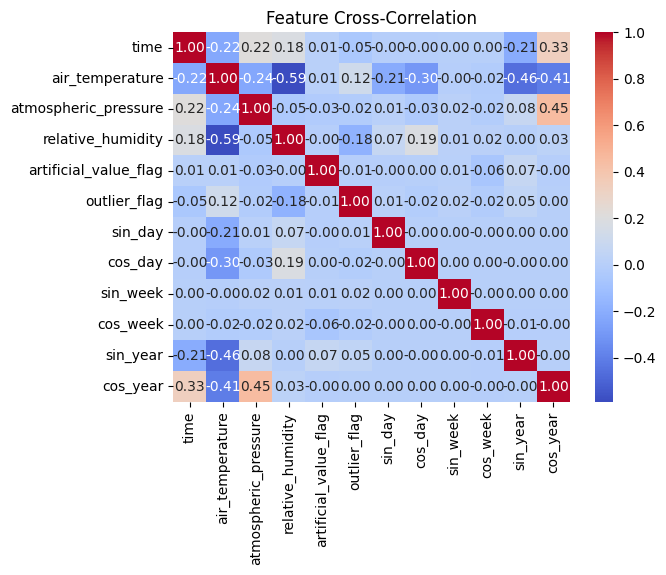

Plotting correlations for openmeteo_la_laguna...


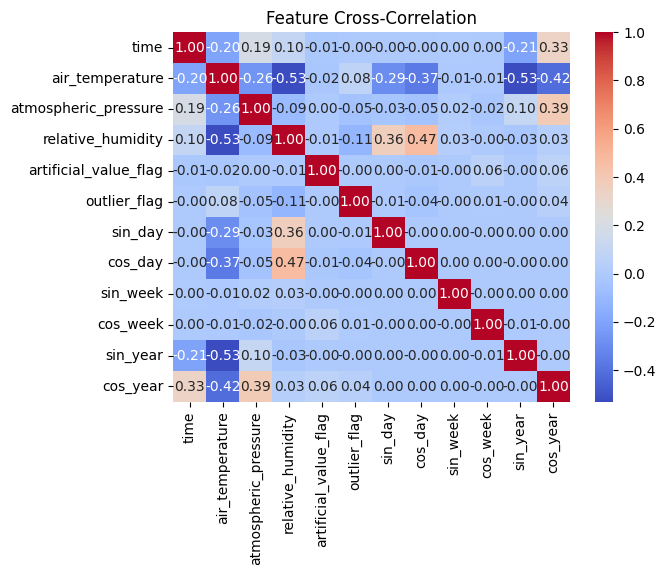

In [42]:
for name, df in dataframes.items():
  print (f"Plotting correlations for {name}...")
  
  correlation_matrix = df.corr()

  # Heatmap for visualization
  sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
  plt.title("Feature Cross-Correlation")
  plt.show()


In [43]:
for df in dataframes.values():
  df.drop(columns=["sin_week", "cos_week"], inplace=True)

## Escritura fichero 

In [44]:
for name, df in dataframes.items():
  df.to_csv("processed_data/" + name + "_features.csv", index=False)